In [1]:
import gstools as gs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
import xarray as xr
import cartopy.crs as ccrs
from cartopy import geodesic as cgeod
from geopy.distance import geodesic 
import cartopy.feature as cfeature
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, Normalize

import matplotlib.cm as cm
from multiprocess import Pool

import matplotlib.colors as mcolors
import cmcrameri.cm as cmc
import os
import scipy.stats as stats


In [2]:
params={     
    'axes.labelsize'  : '16',   
    'axes.titlesize'  : '16',  
    'xtick.labelsize' :'12',
    'ytick.labelsize' :'16',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

# Get stations

In [3]:
df = pd.read_csv("/g/data/k10/dl6968/CLEX_analysis/BoM_daily_stations.csv")
exclude_stn = []
for stn_id in df["ID"]:
    bom_id = str(stn_id).zfill(6)
    if not os.path.exists(f'/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90/{stn_id}_pair_scale_list_all_events.csv'):
        exclude_stn.append(stn_id)
# ## mannually remove some faulty stations
df = df[~df["ID"].isin(exclude_stn)]

## test these stations for Brisbane first
## daily center
## consider number of years
center_stations = []
center_radius = 100
center_lat, center_lon =    -12.4239,  130.8925#-31.9275,  117.9764 #-12.4239,  130.8925
for i in range(0,len(df)):
    station  = (df["Latitude"].iloc[i],  df["Longitude"].iloc[i])
    distance = geodesic((center_lat,center_lon), station).kilometers

    if distance <= center_radius and df["Years"].iloc[i]>=20:
            center_stations.append(df["ID"].iloc[i])

df_center = df[(df["ID"].isin(center_stations)) & (df["End_Year"]>=1960)]   

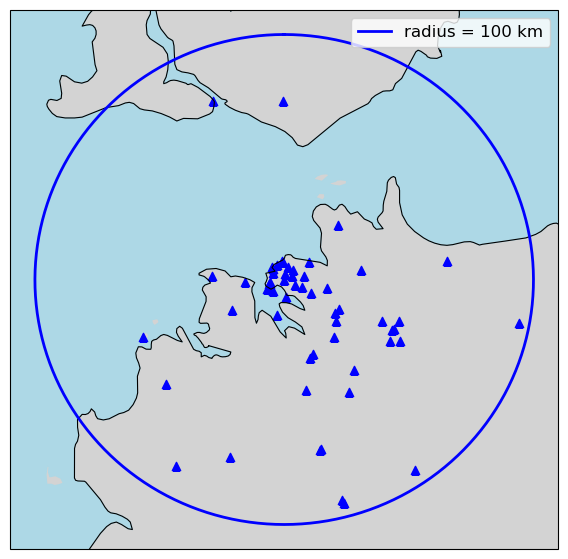

In [4]:
fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
plt.scatter(df_center["Longitude"], df_center["Latitude"],marker="^", color="blue", transform=ccrs.PlateCarree())

# plt.plot(nearby_bom_lon_1min, nearby_bom_lat_1min, "rx", label = "BoM", transform=ccrs.PlateCarree())
g = cgeod.Geodesic()
circle = g.circle(lon=center_lon, lat=center_lat, radius=center_radius * 1000.0)
## do this to remove the gap of the circle
circ_lon = np.append(circle[:,0], circle[0,0])
circ_lat = np.append(circle[:,1], circle[0,1])
# Plot the circle
ax1.plot(circ_lon, circ_lat, color='blue', transform=ccrs.PlateCarree(), label="radius = 100 km")
plt.legend()
# Add coastlines
ax1.coastlines('10m', color="black", linewidth=0.8)
# Add land and ocean with different colors
ax1.add_feature(cfeature.LAND, color='lightgray')  # Land in light gray
ax1.add_feature(cfeature.OCEAN, color='lightblue')  # Ocean in light blue

In [5]:
min_scale = 0
small_dates_all = []
large_dates_all = []
mid_dates_all = []
extreme_dates_all = []

months = np.arange(0,12)+1
months_str = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
small_case = np.zeros((months.shape[0], len(df_center["ID"])))
mid_case = np.zeros((months.shape[0], len(df_center["ID"])))
large_case = np.zeros((months.shape[0], len(df_center["ID"])))

for i, spec_id in enumerate(df_center["ID"]):
    df_scale_p90 = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90/{spec_id}_pair_scale_list_all_events.csv")
    
    small = np.percentile(df_scale_p90[df_scale_p90["scale"]>min_scale]["scale"].values, 33.3)
    large = np.percentile(df_scale_p90[df_scale_p90["scale"]>min_scale]["scale"].values, 66.6)
    
    small_dates = [dates for dates in df_scale_p90[(df_scale_p90["scale"]>min_scale) & (df_scale_p90["scale"]<=small)]["extreme_dates"] if dates not in small_dates_all]
    mid_dates = [dates for dates in df_scale_p90[(df_scale_p90["scale"]>small) & (df_scale_p90["scale"]<=large)]["extreme_dates"] if dates not in mid_dates_all]
    large_dates = [dates for dates in df_scale_p90[(df_scale_p90["scale"]>large)]["extreme_dates"] if dates not in large_dates_all]
    extreme_dates = [dates for dates in df_scale_p90[(df_scale_p90["scale"]>min_scale)]["extreme_dates"] if dates not in extreme_dates_all]
    
    small_dates_all.extend(small_dates)
    mid_dates_all.extend(mid_dates)
    large_dates_all.extend(large_dates)
    extreme_dates_all.extend(extreme_dates)
    ## seasonality for each station
    for j in range(0,len(small_dates)):
        mon_id = int(small_dates[j][5:7])-1
        small_case[mon_id,i] += 1
    for k in range(0,len(mid_dates)):
        mon_id = int(mid_dates[k][5:7])-1
        mid_case[mon_id,i] += 1
    for l in range(0,len(large_dates)):
        mon_id = int(large_dates[l][5:7])-1
        large_case[mon_id,i] += 1


In [6]:
i =0
for dates in small_dates_all:
    if dates in mid_dates_all:
        i+=1

## Seasonality

In [7]:
def calc_ci_2d(data, confidence=0.95, axis=1):
    # Calculate the mean along the specified axis
    means = np.nanmean(data, axis=axis)
    
    # Number of samples along the axis
    n = data.shape[axis]
    
    # Compute the standard error along the specified axis
    std_err = stats.sem(data, axis=axis,nan_policy="omit")
    
    # Calculate the t critical value for the given confidence level
    t_crit = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    
    # Margin of error
    margin_of_error = std_err * t_crit
    
    # Confidence interval bounds
    ci_lower = means - margin_of_error
    ci_upper = means + margin_of_error
    
    return means, ci_lower, ci_upper


In [8]:
small_freq = np.zeros_like(small_case)
mid_freq = np.zeros_like(mid_case)
large_freq = np.zeros_like(large_case)
for j in range(0,small_case.shape[1]):
    small_freq[:,j] = small_case[:,j]/np.sum(small_case[:,j]) *100
    mid_freq[:,j] = mid_case[:,j]/np.sum(mid_case[:,j]) *100
    large_freq[:,j] = large_case[:,j]/np.sum(large_case[:,j]) *100

/jobfs/136384063.gadi-pbs/ipykernel_1866446/700348784.py:7: RuntimeWarning: invalid value encountered in divide
  large_freq[:,j] = large_case[:,j]/np.sum(large_case[:,j]) *100
/jobfs/136384063.gadi-pbs/ipykernel_1866446/700348784.py:6: RuntimeWarning: invalid value encountered in divide
  mid_freq[:,j] = mid_case[:,j]/np.sum(mid_case[:,j]) *100


In [9]:
small_case_mean, small_case_lower, small_case_upper = calc_ci_2d(small_freq)
mid_case_mean, mid_case_lower, mid_case_upper = calc_ci_2d(mid_freq)
large_case_mean, large_case_lower, large_case_upper = calc_ci_2d(large_freq)

In [10]:
small_error =  (small_case_upper - small_case_lower) / 2
mid_error =  (mid_case_upper - mid_case_lower) / 2
large_error =  (large_case_upper - large_case_lower) / 2

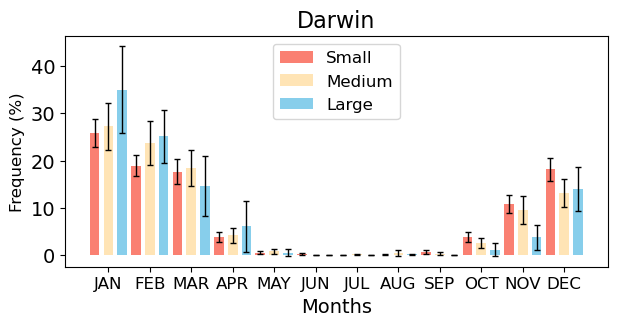

In [11]:
plt.figure(figsize=(7,3))
plt.bar(months*3-1, np.nanmean(small_freq,axis=1), yerr=small_error,color="salmon", label = "Small", 
        width=0.7,capsize=2,error_kw={'elinewidth': 1}) # 
plt.bar(months*3, np.nanmean(mid_freq,axis=1), yerr=mid_error, color="moccasin", label = "Medium",
        width=0.7,capsize=2,error_kw={'elinewidth': 1}) # 

plt.bar(months*3+1, np.nanmean(large_freq,axis=1), yerr=large_error, color="skyblue",label = "Large",
        width=0.7,capsize=2,error_kw={'elinewidth': 1}) # 
plt.legend(loc="upper center")
plt.xlabel("Months",fontsize=14)
plt.ylabel("Frequency (%)",fontsize=12)
plt.title("Darwin")
plt.yticks(fontsize=14)
_ = plt.xticks(months*3,months_str)

# TP vs BL

In [4]:
ds_tp = xr.open_dataset("/scratch/k10/dl6968/ERA5_AU/Melb/garden_clip/tp_clip.nc")
ds_BL = xr.open_dataset("/scratch/k10/dl6968/ERA5_AU/Melb/garden_clip/BL_clip.nc")

In [18]:
tp = ds_tp["tp"].sel(time=slice(ds_BL.time[0], ds_BL.time[-1])) * 10**3 * 24 
BL = ds_BL["BL"].sel(time=slice(tp.time[0], tp.time[-1]))
assert BL.shape == tp.shape, "BL and tp must have the same dimensions"


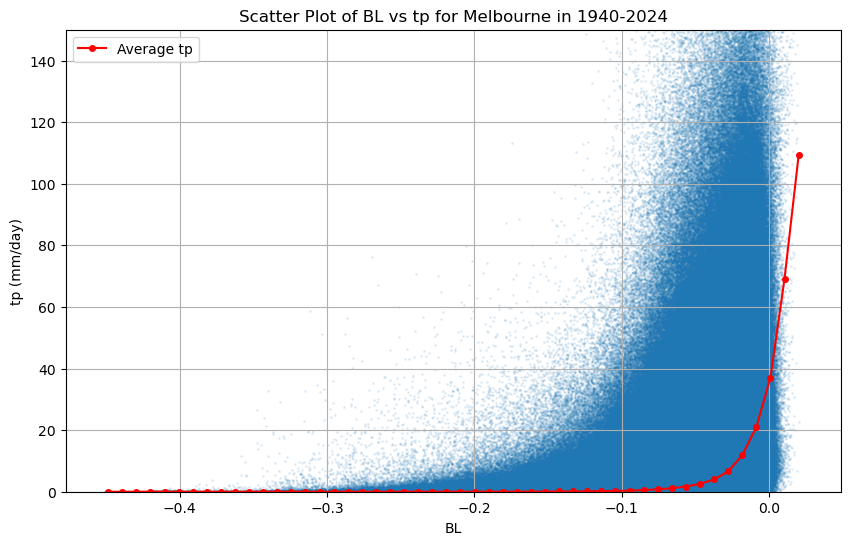

In [20]:
# Flatten the arrays to 1D for scatter plotting
BL_flat = BL.values.flatten()
tp_flat = tp.values.flatten()
region = "Melbourne"
year = "1940-2024"
# Scatter plot with small dots
plt.figure(figsize=(10, 6))
plt.scatter(BL_flat, tp_flat, s=1, alpha=0.1)  # s=1 makes the dots smaller, alpha=0.1 adds transparency

# Binning BL and calculating the average tp for each bin
bin_count = 50  # Number of bins for BL
bins = np.linspace(BL_flat.min(), BL_flat.max(), bin_count + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])  # Calculate the bin centers
tp_bin_means = np.array([tp_flat[(BL_flat >= bins[i]) & (BL_flat < bins[i+1])].mean() 
                         for i in range(bin_count)])

# Overlay the average tp values as a red line
plt.plot(bin_centers, tp_bin_means, 'ro-', markersize=4, label='Average tp')

# Set y-axis limits
plt.ylim(0, 150)
plt.xlabel('BL')
plt.ylabel('tp (mm/day)')
plt.title(f'Scatter Plot of BL vs tp for {region} in {year}')
plt.legend()
plt.grid(True)
plt.show()

# Composites

In [12]:
from dask.distributed import Client
client = Client(n_workers=24, threads_per_worker=1)  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 24
Total threads: 24,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45467,Workers: 24
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 125.19 GiB
Comm: tcp://127.0.0.1:37705,Total threads: 1
Dashboard: /proxy/39345/status,Memory: 5.22 GiB
Nanny: tcp://127.0.0.1:41285,


In [6]:
# extreme_dates = np.load("/g/data/k10/dl6968/Rain_gauge_scale/data/Melb_extreme_dates.npy",allow_pickle=True)
# clusters = np.load("/g/data/k10/dl6968/Rain_gauge_scale/data/Melb_clusters.npy",allow_pickle=True)

In [13]:
# Brisbane [143,155],[-33,-22]
# Melbourne [135,155], [-45,-27]
# Perth [115,130], [-37,-27]
# Darwin [112, 145], [-30, -9]
x_extent = [112, 145]
y_extent = [-30, -9]

In [14]:
def calc_ci_3d(data, confidence=0.95, axis=0):
    """
    Compute the mean and confidence interval over a specified axis for a 3D array.
    
    Parameters:
        data (np.ndarray): 3D array with shape (time, lat, lon)
        confidence (float): Confidence level (default is 95%)
        axis (int): Axis along which to compute the statistics (default is 0, meaning time)
    
    Returns:
        mean (np.ndarray): Mean over time (lat, lon)
        ci_lower (np.ndarray): Lower confidence bound (lat, lon)
        ci_upper (np.ndarray): Upper confidence bound (lat, lon)
    """
    means = np.mean(data, axis=axis)  # Compute mean over time
    n = data.shape[axis]  # Number of time steps
    std_err = stats.sem(data, axis=axis)  # Standard error along time
    t_crit = stats.t.ppf((1 + confidence) / 2, df=n - 1)  # t critical value

    margin_of_error = std_err * t_crit  # Confidence interval margin
    ci_lower = means - margin_of_error
    ci_upper = means + margin_of_error

    return means, ci_lower, ci_upper

In [15]:
def remove_time_mean(x):
    return x - x.mean(dim="time")

## mslp

In [16]:
ds_msl = xr.open_mfdataset("/scratch/k10/dl6968/ERA5_AU/msl/*.nc",parallel=True, chunks={"time":100}).drop_duplicates(dim="time",keep="first")
ds_msl_daily = ds_msl.resample(time="D").mean(dim="time").chunk({"time":10})

In [17]:
%%time
## 14 minutes
# ds_anom = ds_msl_daily.groupby("time.dayofyear").map(remove_time_mean)
# msl_anom = ds_anom["msl"].compute()
# msl_anom.to_dataset(name="msl").to_netcdf("/scratch/k10/dl6968/ERA5_AU/msl_anom_daily.nc")
ds_anom = xr.open_dataset("/scratch/k10/dl6968/ERA5_AU/msl_anom_daily.nc")
msl_anom = ds_anom["msl"]


CPU times: user 6.53 s, sys: 462 ms, total: 6.99 s
Wall time: 6.97 s


In [21]:
msl_day_anom_extreme = msl_anom.sel(time=extreme_dates_all).load()

In [22]:
small_msl_all = msl_day_anom_extreme.sel(time=small_dates_all)
mid_msl_all = msl_day_anom_extreme.sel(time=mid_dates_all)
large_msl_all = msl_day_anom_extreme.sel(time=large_dates_all)


Text(0.5, 0, 'MSLP anomaly (hPa)')

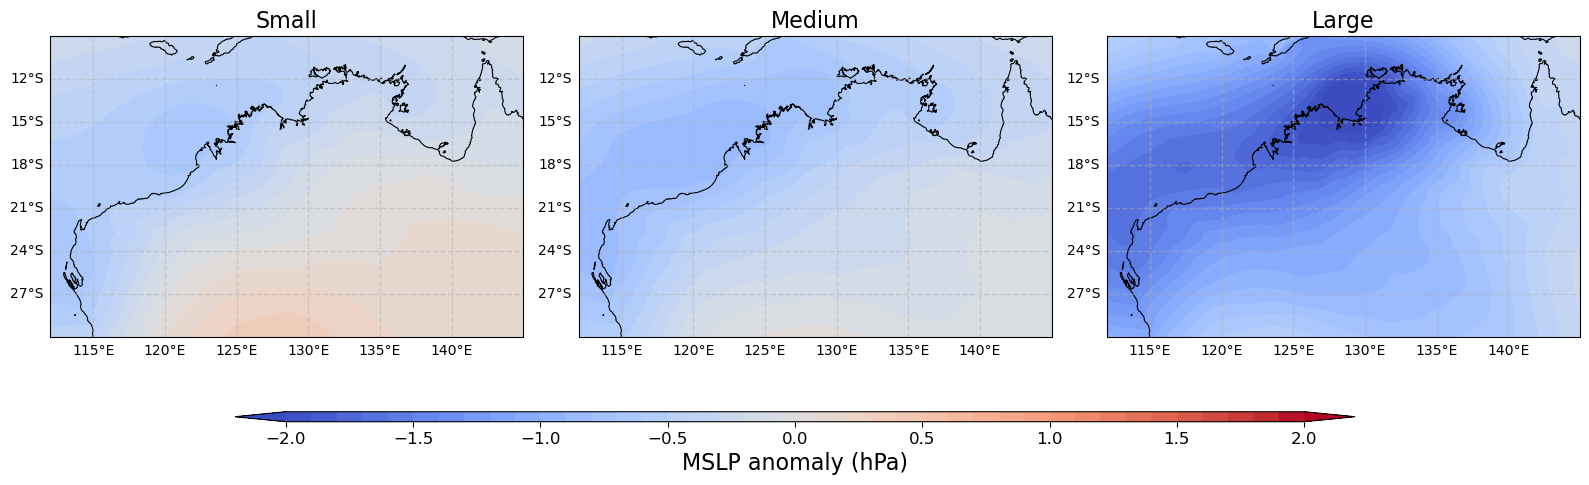

In [23]:
fig = plt.figure(figsize=(16,5))
cmap = "coolwarm" # cmc.devon
lvls = np.arange(-2,2.1,0.1)
ax1 = fig.add_subplot(131,projection=ccrs.PlateCarree())
CS1 = ax1.contourf(small_msl_all.longitude, small_msl_all.latitude, small_msl_all.mean(dim="time")/100, 
                   levels=lvls,extend="both",
                 transform=ccrs.PlateCarree(), cmap=cmap)
# cbar1 = plt.colorbar(CS1, ax=ax1, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar1.set_label("MSLP anomaly (hPa)") 
ax1.coastlines('10m', color="black",linewidth=0.8)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
# ax1.clabel(CS1, CS1.levels, inline=True,  fontsize=12)

ax1.set_ylim(y_extent)
ax1.set_xlim(x_extent)
ax1.set_title("Small")

ax2 = fig.add_subplot(132,projection=ccrs.PlateCarree())
CS2 = ax2.contourf(mid_msl_all.longitude, mid_msl_all.latitude, mid_msl_all.mean(dim="time")/100, 
                   levels=lvls,extend="both",
                 transform=ccrs.PlateCarree(), cmap=cmap)
# cbar2 = plt.colorbar(CS2, ax=ax2, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar2.set_label("MSLP anomaly (hPa)") 
# ax2.clabel(CS2, CS2.levels, inline=True,  fontsize=12)
ax2.coastlines('10m', color="black",linewidth=0.8)

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
ax2.set_ylim(y_extent)
ax2.set_xlim(x_extent)
ax2.set_title("Medium")


ax3 = fig.add_subplot(133,projection=ccrs.PlateCarree())
CS3 = ax3.contourf(large_msl_all.longitude, large_msl_all.latitude, large_msl_all.mean(dim="time")/100, 
                   levels=lvls,extend="both",
                 transform=ccrs.PlateCarree(), cmap=cmap)
# cbar3 = plt.colorbar(CS3, ax=ax3, orientation='hroizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar3.set_label("MSLP anomaly (hPa)") 
# ax3.clabel(CS3, CS3.levels, inline=True,  fontsize=12)
ax3.coastlines('10m', color="black",linewidth=0.8)

gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
ax3.set_ylim(y_extent)
ax3.set_xlim(x_extent)
ax3.set_title("Large")
plt.tight_layout()
fig.subplots_adjust(bottom = 0.15)


cbar_ax = fig.add_axes([0.15, 0.09, 0.7, 0.02]) #[left, bottom, width, height]
cbar = fig.colorbar(CS3,  cax = cbar_ax, orientation = "horizontal",extend="both")
cbar.ax.set_xlabel("MSLP anomaly (hPa)")
# plt.tight_layout()

## w at 500 hPa

In [24]:
ds_w500 = xr.open_mfdataset("/scratch/k10/dl6968/ERA5_AU/w_500/*.nc",parallel=True, chunks={"time":100})
ds_w500_daily = ds_w500.resample(time="D").mean(dim="time").chunk({"time":10})

In [32]:
## 10 minutes
# ds_anom_w = ds_w500_daily.groupby("time.dayofyear").map(remove_time_mean)
# w_anom = ds_anom_w["w"].compute()
# w_anom.to_dataset(name="w").to_netcdf("/scratch/k10/dl6968/ERA5_AU/w500_anom_daily.nc")

CPU times: user 4min 8s, sys: 5.14 s, total: 4min 13s
Wall time: 4min 10s


In [25]:
%%time
ds_w_anom = xr.open_dataset("/scratch/k10/dl6968/ERA5_AU/w500_anom_daily.nc")
w_anom = ds_w_anom["w"]

CPU times: user 57.8 ms, sys: 15.8 ms, total: 73.7 ms
Wall time: 59.3 ms


In [26]:
w500_extreme_anom = w_anom.sel(time=extreme_dates_all)


In [27]:
small_w500_all = w500_extreme_anom.sel(time=small_dates_all)
mid_w500_all = w500_extreme_anom.sel(time=mid_dates_all)
large_w500_all = w500_extreme_anom.sel(time=large_dates_all)

Text(0.5, 0, '$\\omega$ anomaly (Pa s$^{-1}$)')

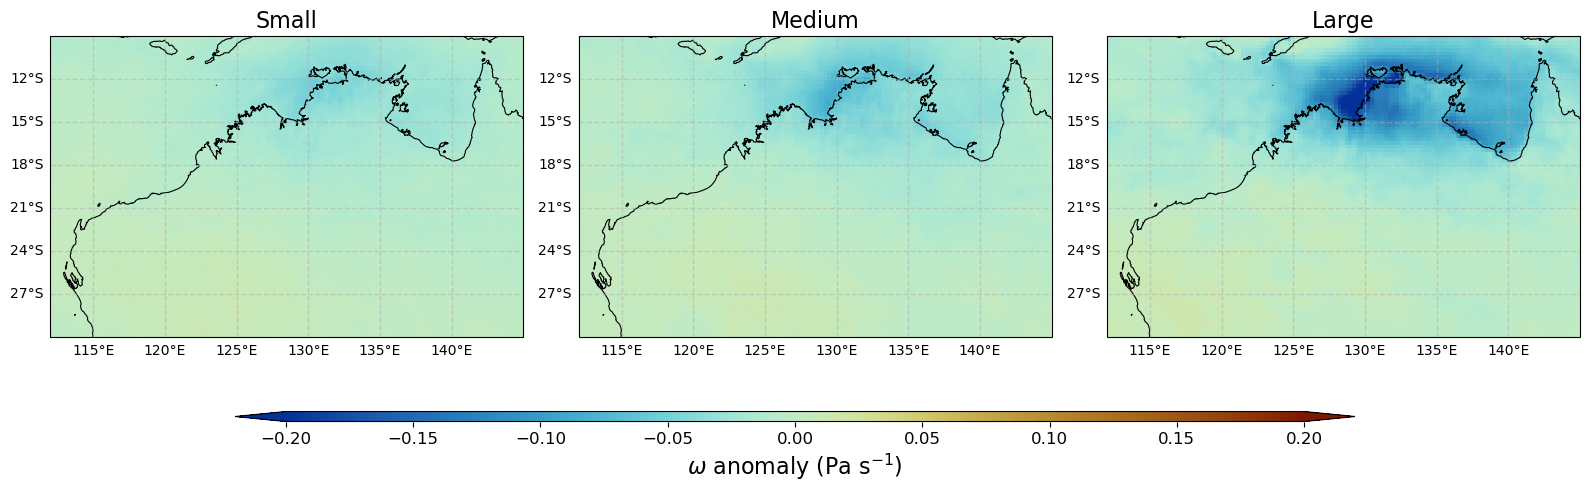

In [28]:
fig = plt.figure(figsize=(16, 5))

# First subplot
ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
img1 = ax1.pcolor(small_w500_all.longitude, small_w500_all.latitude, 
                 small_w500_all.mean(dim="time"),
                 transform=ccrs.PlateCarree(), cmap="cmc.roma_r", 
                 vmin=-0.2, vmax=0.2)
ax1.coastlines('10m', color="black", linewidth=0.8)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, alpha=0.5, linestyle='--')
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels
ax1.set_ylim(y_extent)
ax1.set_xlim(x_extent)
ax1.set_title("Small")

# First colorbar
# cbar1 = plt.colorbar(img1, ax=ax1, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar1.set_label("$\omega$ anomaly (Pa s$^{-1}$)")   # Change to desired colorbar title

# Second subplot
ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
img2 = ax2.pcolor(mid_w500_all.longitude, mid_w500_all.latitude, 
                 mid_w500_all.mean(dim="time"),
                 transform=ccrs.PlateCarree(), cmap="cmc.roma_r", 
                 vmin=-0.2, vmax=0.2)
ax2.coastlines('10m', color="black", linewidth=0.8)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, alpha=0.5, linestyle='--')
gl2.top_labels=False   # suppress top labels
gl2.right_labels=False # suppress right labels
ax2.set_ylim(y_extent)
ax2.set_xlim(x_extent)
ax2.set_title("Medium")

# Second colorbar
# cbar2 = plt.colorbar(img2, ax=ax2, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  
# cbar2.set_label("$\omega$ anomaly (Pa s$^{-1}$)")   # Change to desired colorbar title


# Third subplot
ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
img3 = ax3.pcolor(large_w500_all.longitude, large_w500_all.latitude, 
                 large_w500_all.mean(dim="time"),
                 transform=ccrs.PlateCarree(), cmap="cmc.roma_r", 
                 vmin=-0.2, vmax=0.2)
ax3.coastlines('10m', color="black", linewidth=0.8)
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, alpha=0.5, linestyle='--')
gl3.top_labels=False   # suppress top labels
gl3.right_labels=False # suppress right labels
ax3.set_ylim(y_extent)
ax3.set_xlim(x_extent)
ax3.set_title("Large")

# third colorbar
# cbar3 = plt.colorbar(img3, ax=ax3, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  
# cbar3.set_label("$\omega$ anomaly (Pa s$^{-1}$)")  # Change to desired colorbar title

plt.tight_layout()
fig.subplots_adjust(bottom = 0.15)


cbar_ax = fig.add_axes([0.15, 0.09, 0.7, 0.02]) #[left, bottom, width, height]
cbar = fig.colorbar(img3,  cax = cbar_ax, orientation = "horizontal",extend="both")
cbar.ax.set_xlabel("$\omega$ anomaly (Pa s$^{-1}$)")

## TP

In [29]:
ds_tp = xr.open_mfdataset("/scratch/k10/dl6968/ERA5_AU/tp/*.nc",parallel=True, chunks={"time":100})


In [30]:
ds_tp_daily = ds_tp.resample(time="D").sum(dim="time")


In [31]:
%%time
ds_tp_extreme = ds_tp_daily.sel(time=extreme_dates_all)
ds_tp_extreme = ds_tp_extreme.compute()

CPU times: user 55.7 s, sys: 6.31 s, total: 1min 1s
Wall time: 1min 28s


In [32]:
small_tp_all = ds_tp_extreme.sel(time=small_dates_all)["tp"]* 10**3  # Convert unit from m to mm/day
mid_tp_all = ds_tp_extreme.sel(time=mid_dates_all)["tp"]* 10**3  # Convert unit from m to mm/day
large_tp_all = ds_tp_extreme.sel(time=large_dates_all)["tp"]* 10**3   # Convert unit from m to mm/day


Text(0.5, 0, 'Total precipitation (mm day$^{-1}$)')

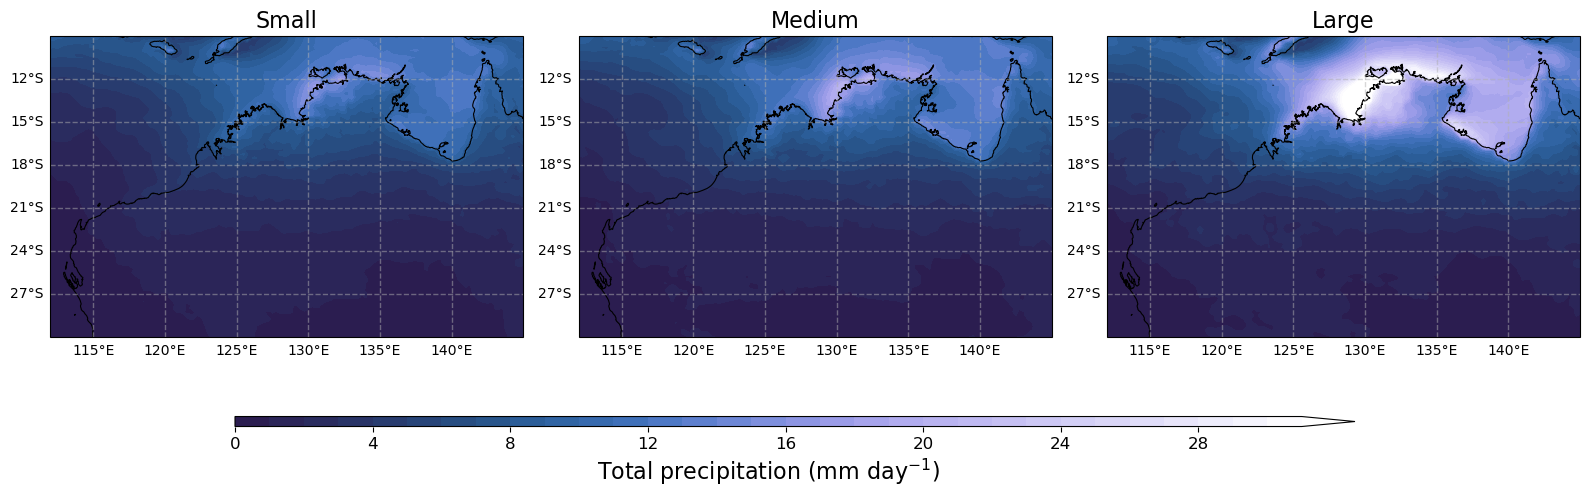

In [34]:
fig = plt.figure(figsize=(16,5))
lvl_max =  32
lvl_int = 1
ax1 = fig.add_subplot(131,projection=ccrs.PlateCarree())
CS1 = ax1.contourf(small_tp_all.longitude, small_tp_all.latitude, small_tp_all.mean(dim="time"),  
                   levels=np.arange(0,lvl_max,lvl_int),extend="max",
                 transform=ccrs.PlateCarree(), cmap="cmc.devon")
# cbar1 = plt.colorbar(CS1, ax=ax1, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar1.set_label("Total precipitation (mm day$^{-1}$)") 
ax1.coastlines('10m', color="black",linewidth=0.8)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
# ax1.clabel(CS1, CS1.levels, inline=True,  fontsize=12)

ax1.set_ylim(y_extent)
ax1.set_xlim(x_extent)
ax1.set_title("Small")

ax2 = fig.add_subplot(132,projection=ccrs.PlateCarree())
CS2 = ax2.contourf(mid_tp_all.longitude, mid_tp_all.latitude, mid_tp_all.mean(dim="time"),  
                   levels=np.arange(0,lvl_max,lvl_int),extend="max",
                 transform=ccrs.PlateCarree(), cmap="cmc.devon")
# cbar2 = plt.colorbar(CS2, ax=ax2, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar2.set_label("Total precipitation (mm day$^{-1}$)") 
# ax2.clabel(CS2, CS2.levels, inline=True,  fontsize=12)
ax2.coastlines('10m', color="black",linewidth=0.8)

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
ax2.set_ylim(y_extent)
ax2.set_xlim(x_extent)
ax2.set_title("Medium")


ax3 = fig.add_subplot(133,projection=ccrs.PlateCarree())
CS3 = ax3.contourf(large_tp_all.longitude, large_tp_all.latitude, large_tp_all.mean(dim="time"), 
                   levels=np.arange(0,lvl_max,lvl_int),extend="max",
                 transform=ccrs.PlateCarree(), cmap="cmc.devon")
# cbar3 = plt.colorbar(CS3, ax=ax3, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar3.set_label("Total precipitation (mm day$^{-1}$)") 
# ax3.clabel(CS3, CS3.levels, inline=True,  fontsize=12)
ax3.coastlines('10m', color="black",linewidth=0.8)

gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
ax3.set_ylim(y_extent)
ax3.set_xlim(x_extent)
ax3.set_title("Large")
plt.tight_layout()
fig.subplots_adjust(bottom = 0.17)


cbar_ax = fig.add_axes([0.15, 0.09, 0.7, 0.02]) #[left, bottom, width, height]
cbar = fig.colorbar(CS3,  cax = cbar_ax, orientation = "horizontal",extend="max")
cbar.ax.set_xlabel("Total precipitation (mm day$^{-1}$)")

## u10 and v10

In [49]:
ds_u10 = xr.open_mfdataset("/scratch/k10/dl6968/ERA5_AU/10u/*.nc",parallel=True, chunks={"time":100})
ds_u10_daily = ds_u10.resample(time="D").mean(dim="time")

In [52]:
%%time
ds_anom_u10 = ds_u10_daily.groupby("time.dayofyear").map(remove_time_mean)


CPU times: user 4min 16s, sys: 5.49 s, total: 4min 21s
Wall time: 4min 19s


In [53]:
%%time
u10_anom = ds_anom_u10["u10"].compute()
u10_anom.to_dataset(name="u10").to_netcdf("/scratch/k10/dl6968/ERA5_AU/u10_anom_daily.nc")

CPU times: user 4min 32s, sys: 43.8 s, total: 5min 16s
Wall time: 6min 33s


In [54]:
%%time
ds_v10 = xr.open_mfdataset("/scratch/k10/dl6968/ERA5_AU/10v/*.nc",parallel=True, chunks={"time":100})
ds_v10_daily = ds_v10.resample(time="D").mean(dim="time")


CPU times: user 1min 37s, sys: 3.49 s, total: 1min 41s
Wall time: 1min 40s


In [55]:
%%time
ds_anom_v10 = ds_v10_daily.groupby("time.dayofyear").map(remove_time_mean)
v10_anom = ds_anom_v10["v10"].compute()
v10_anom.to_dataset(name="v10").to_netcdf("/scratch/k10/dl6968/ERA5_AU/v10_anom_daily.nc")

CPU times: user 8min 20s, sys: 38.7 s, total: 8min 59s
Wall time: 10min 15s


In [56]:
u10_extreme = u10_anom.sel(time=extreme_dates_all)
v10_extreme = v10_anom.sel(time=extreme_dates_all)

In [57]:
small_u10_all= u10_anom.sel(time=small_dates_all) #-u10_daily_mean["u10"]
mid_u10_all = u10_anom.sel(time=mid_dates_all) #-u10_daily_mean["u10"]
large_u10_all= u10_anom.sel(time=large_dates_all) #-u10_daily_mean["u10"]

small_v10_all= v10_anom.sel(time=small_dates_all) #-v10_daily_mean["v10"]
mid_v10_all = v10_anom.sel(time=mid_dates_all) #-v10_daily_mean["v10"]
large_v10_all= v10_anom.sel(time=large_dates_all) #-v10_daily_mean["v10"]

In [58]:
small_wind_all = np.sqrt(small_u10_all*2+small_v10_all**2)
mid_wind_all = np.sqrt(mid_u10_all*2+mid_v10_all**2)
large_wind_all = np.sqrt(large_u10_all*2+large_v10_all**2)


/home/565/dl6968/miniconda3/envs/myenv/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


Text(0.5, 0, 'Wind speed anomaly (m s$^{-1}$)')

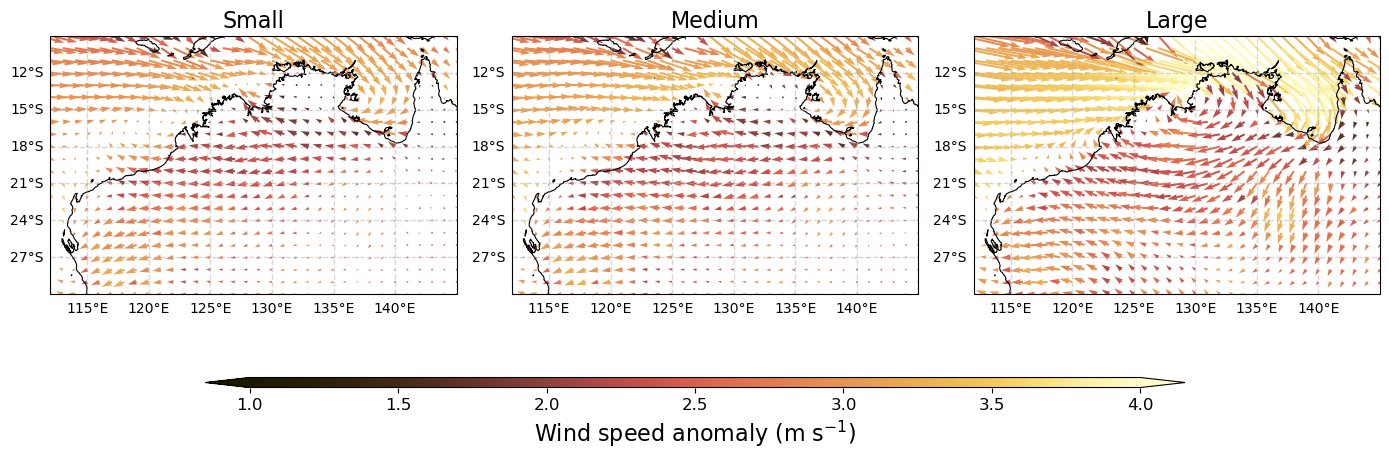

In [63]:
fig = plt.figure(figsize=(14, 5))
spacing = 4
# First subplot
ax1 = fig.add_subplot(131, projection=ccrs.PlateCarree())
img1 = ax1.quiver(small_u10_all.longitude[::spacing], small_u10_all.latitude[::spacing], 
                 small_u10_all.mean(dim="time")[::spacing,::spacing],
                  small_v10_all.mean(dim="time")[::spacing,::spacing], 
                  small_wind_all.mean(dim="time")[::spacing,::spacing],scale=1/0.05,width=0.005, 
                 transform=ccrs.PlateCarree(), cmap = "cmc.lajolla", clim=[1,4])
# cbar1 = plt.colorbar(img1, ax=ax1, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  
# cbar1.set_label("Wind speed (m s$^{-1}$)")  # Change to desired colorbar title
ax1.coastlines('10m', color="black", linewidth=0.8)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, alpha=0.5, linestyle='--')
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels
ax1.set_ylim(y_extent)
ax1.set_xlim(x_extent)
ax1.set_title("Small")

# # First colorbar
# cbar1 = plt.colorbar(img1, ax=ax1, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar1.set_label("w (Pa/s)")  # Change to desired colorbar title

# Second subplot
ax2 = fig.add_subplot(132, projection=ccrs.PlateCarree())
img2 = ax2.quiver(mid_u10_all.longitude[::spacing], mid_u10_all.latitude[::spacing], 
                 mid_u10_all.mean(dim="time")[::spacing,::spacing],
                  mid_v10_all.mean(dim="time")[::spacing,::spacing], 
                  mid_wind_all.mean(dim="time")[::spacing,::spacing],scale=1/0.05,width=0.005, 
                 transform=ccrs.PlateCarree(), cmap = "cmc.lajolla", clim=[1,4])
# cbar2 = plt.colorbar(img2, ax=ax2, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  
# cbar2.set_label("Wind speed (m s$^{-1}$)")  # Change to desired colorbar title
ax2.coastlines('10m', color="black", linewidth=0.8)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, alpha=0.5, linestyle='--')
gl2.top_labels=False   # suppress top labels
gl2.right_labels=False # suppress right labels
ax2.set_ylim(y_extent)
ax2.set_xlim(x_extent)
ax2.set_title("Medium")

# # Second colorbar
# cbar2 = plt.colorbar(img2, ax=ax2, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  
# cbar2.set_label("w (Pa/s)")  # Change to desired colorbar title

ax3 = fig.add_subplot(133, projection=ccrs.PlateCarree())
img3 = ax3.quiver(large_u10_all.longitude[::spacing], large_u10_all.latitude[::spacing], 
                 large_u10_all.mean(dim="time")[::spacing,::spacing],
                  large_v10_all.mean(dim="time")[::spacing,::spacing], 
                  large_wind_all.mean(dim="time")[::spacing,::spacing],scale=1/0.05,width=0.005, 
                 transform=ccrs.PlateCarree(), cmap = "cmc.lajolla", clim=[1,4])
# cbar3 = plt.colorbar(img3, ax=ax3, orientation='vertical', pad=0.1, shrink=0.7,extend="both")  
# cbar3.set_label("Wind speed (m s$^{-1}$)")  # Change to desired colorbar title
ax3.coastlines('10m', color="black", linewidth=0.8)
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, alpha=0.5, linestyle='--')
gl3.top_labels=False   # suppress top labels
gl3.right_labels=False # suppress right labels
ax3.set_ylim(y_extent)
ax3.set_xlim(x_extent)
ax3.set_title("Large")

plt.tight_layout()
fig.subplots_adjust(bottom = 0.10)


cbar_ax = fig.add_axes([0.15, 0.09, 0.7, 0.02]) #[left, bottom, width, height]
cbar = fig.colorbar(img3,  cax = cbar_ax, orientation = "horizontal",extend="both")
cbar.ax.set_xlabel("Wind speed anomaly (m s$^{-1}$)")

In [253]:
small_u10_group = []
mid_u10_group = []
large_u10_group = []

small_v10_group = []
mid_v10_group = []
large_v10_group = []

small_wind_group = []
mid_wind_group = []
large_wind_group = []

for i, spec_id in enumerate(df_center["ID"]):
    df_scale_p90 = pd.read_csv(f"/g/data/k10/dl6968/Rain_gauge_scale/data/all_AU_fixed/{spec_id}_scale_list_all_events.csv")
    
    small = np.percentile(df_scale_p90[df_scale_p90["scale"]>min_scale]["scale"].values, 33.3)
    large = np.percentile(df_scale_p90[df_scale_p90["scale"]>min_scale]["scale"].values, 66.6)
    
    small_dates = [dates for dates in df_scale_p90[(df_scale_p90["scale"]>min_scale) & (df_scale_p90["scale"]<=small)]["extreme_dates"]]
    mid_dates = [dates for dates in df_scale_p90[(df_scale_p90["scale"]>small) & (df_scale_p90["scale"]<=large)]["extreme_dates"]]
    large_dates = [dates for dates in df_scale_p90[(df_scale_p90["scale"]>large)]["extreme_dates"]]
    small_u10 = ds_u10_extreme.sel(time=small_dates)["u10"]
    mid_u10 = ds_u10_extreme.sel(time=mid_dates)["u10"]
    large_u10 = ds_u10_extreme.sel(time=large_dates)["u10"]
    small_u10_group.append(small_u10.mean(dim="time").values)
    mid_u10_group.append(mid_u10.mean(dim="time").values)
    large_u10_group.append(large_u10.mean(dim="time").values)

    small_v10 = ds_v10_extreme.sel(time=small_dates)["v10"]
    mid_v10 = ds_v10_extreme.sel(time=mid_dates)["v10"]
    large_v10 = ds_v10_extreme.sel(time=large_dates)["v10"]
    
    small_v10_group.append(small_v10.mean(dim="time").values)
    mid_v10_group.append(mid_v10.mean(dim="time").values)
    large_v10_group.append(large_v10.mean(dim="time").values)
    
    small_wind = np.sqrt(small_u10*2+small_v10**2)
    mid_wind = np.sqrt(mid_u10*2+mid_v10**2)
    large_wind = np.sqrt(large_u10*2+large_v10**2)
    small_wind_group.append(small_wind.mean(dim="time").values)
    mid_wind_group.append(mid_wind.mean(dim="time").values)
    large_wind_group.append(large_wind.mean(dim="time").values)


/home/565/dl6968/miniconda3/envs/myenv/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/565/dl6968/miniconda3/envs/myenv/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/565/dl6968/miniconda3/envs/myenv/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/565/dl6968/miniconda3/envs/myenv/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/565/dl6968/miniconda3/envs/myenv/lib/python3.9/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/565/dl6968/miniconda3/envs/myenv/lib/python3.9/site-packages/xarray/core/comput

In [254]:
small_u10_mean, small_u10_lower, small_u10_upper = calc_ci_3d(np.array(small_u10_group))
mid_u10_mean, mid_u10_lower, mid_u10_upper = calc_ci_3d(np.array(mid_u10_group))
large_u10_mean, large_u10_lower, large_u10_upper = calc_ci_3d(np.array(large_u10_group))

In [255]:
small_v10_mean, small_v10_lower, small_v10_upper = calc_ci_3d(np.array(small_v10_group))
mid_v10_mean, mid_v10_lower, mid_v10_upper = calc_ci_3d(np.array(mid_v10_group))
large_v10_mean, large_v10_lower, large_v10_upper = calc_ci_3d(np.array(large_v10_group))
small_wind_mean, small_wind_lower, small_wind_upper = calc_ci_3d(np.array(small_wind_group))
mid_wind_mean, mid_wind_lower, mid_wind_upper = calc_ci_3d(np.array(mid_wind_group))
large_wind_mean, large_wind_lower, large_wind_upper = calc_ci_3d(np.array(large_wind_group))

In [64]:
client.close()

2025-02-20 10:19:07,735 - distributed.nanny - WARNING - Worker process still alive after 3.1999961853027346 seconds, killing
2025-02-20 10:19:07,738 - distributed.nanny - WARNING - Worker process still alive after 3.1999990844726565 seconds, killing
2025-02-20 10:19:07,740 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2025-02-20 10:19:07,741 - distributed.nanny - WARNING - Worker process still alive after 3.1999989318847657 seconds, killing
2025-02-20 10:19:07,742 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2025-02-20 10:19:07,743 - distributed.nanny - WARNING - Worker process still alive after 3.199999389648438 seconds, killing
2025-02-20 10:19:07,744 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
2025-02-20 10:19:07,746 - distributed.nanny - WARNING - Worker process still alive after 3.1999992370605472 seconds, killing
20

## vertical stack

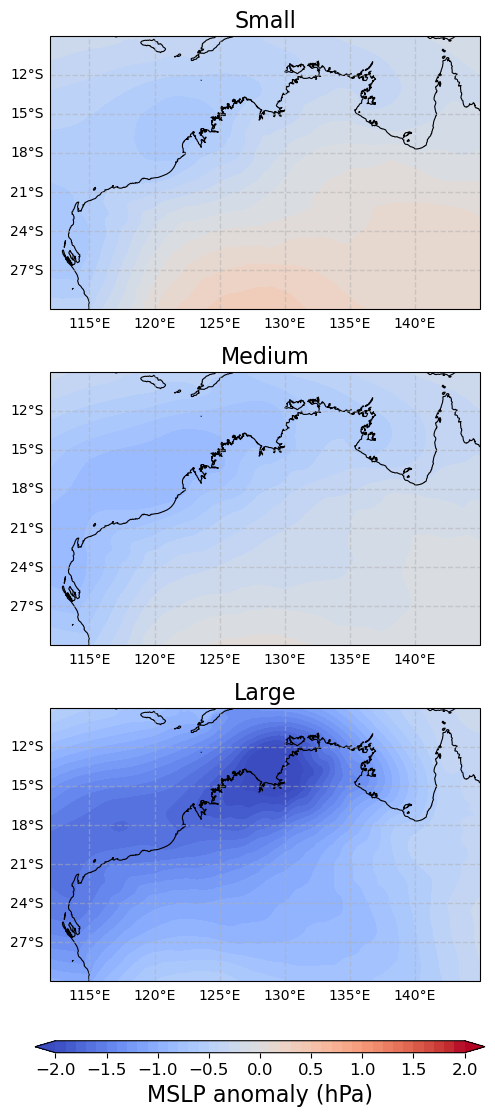

In [35]:
fig = plt.figure(figsize=(5,12))
cmap = "coolwarm" # cmc.devon
ax1 = fig.add_subplot(311,projection=ccrs.PlateCarree())
CS1 = ax1.contourf(small_msl_all.longitude, small_msl_all.latitude, small_msl_all.mean(dim="time")/100, levels=np.arange(-2,2.1,0.1),extend="both",
                 transform=ccrs.PlateCarree(), cmap=cmap)
# cbar1 = plt.colorbar(CS1, ax=ax1, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar1.set_label("MSLP anomaly (hPa)") 
ax1.coastlines('10m', color="black",linewidth=0.8)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
# ax1.clabel(CS1, CS1.levels, inline=True,  fontsize=12)

ax1.set_ylim(y_extent)
ax1.set_xlim(x_extent)
ax1.set_title("Small")
plt.tight_layout()

ax2 = fig.add_subplot(312,projection=ccrs.PlateCarree())
CS2 = ax2.contourf(mid_msl_all.longitude, mid_msl_all.latitude, mid_msl_all.mean(dim="time")/100, levels=np.arange(-2,2.1,0.1),extend="both",
                 transform=ccrs.PlateCarree(), cmap=cmap)
# cbar2 = plt.colorbar(CS2, ax=ax2, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar2.set_label("MSLP anomaly (hPa)") 
# ax2.clabel(CS2, CS2.levels, inline=True,  fontsize=12)
ax2.coastlines('10m', color="black",linewidth=0.8)

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
ax2.set_ylim(y_extent)
ax2.set_xlim(x_extent)
ax2.set_title("Medium")
plt.tight_layout()

ax3 = fig.add_subplot(313,projection=ccrs.PlateCarree())
CS3 = ax3.contourf(large_msl_all.longitude, large_msl_all.latitude, large_msl_all.mean(dim="time")/100, levels=np.arange(-2,2.1,0.1),extend="both",
                 transform=ccrs.PlateCarree(), cmap=cmap)
# cbar3 = plt.colorbar(CS3, ax=ax3, orientation='hroizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar3.set_label("MSLP anomaly (hPa)") 
# ax3.clabel(CS3, CS3.levels, inline=True,  fontsize=12)
ax3.coastlines('10m', color="black",linewidth=0.8)

gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
ax3.set_ylim(y_extent)
ax3.set_xlim(x_extent)
ax3.set_title("Large")
plt.tight_layout()
fig.subplots_adjust(bottom = 0.1)


cbar_ax = fig.add_axes([0.08, 0.09, 0.9, 0.01]) #[left, bottom, width, height]
cbar = fig.colorbar(CS3,  cax = cbar_ax, orientation = "horizontal",extend="both")
cbar.ax.set_xlabel("MSLP anomaly (hPa)")
# plt.tight_layout()
plt.savefig("/g/data/k10/dl6968/Rain_gauge_scale/figures/Darwin_composites_MSLP_anom.png",dpi=200)

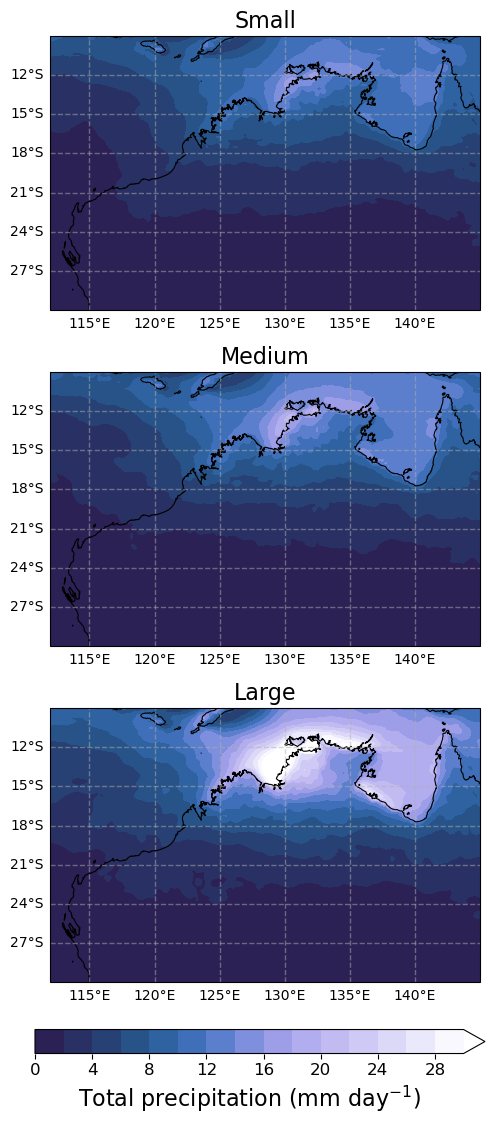

In [36]:
fig = plt.figure(figsize=(5,12))
lvl_max = 32 # 32
ax1 = fig.add_subplot(311,projection=ccrs.PlateCarree())
CS1 = ax1.contourf(small_tp_all.longitude, small_tp_all.latitude, small_tp_all.mean(dim="time"),  levels=np.arange(0,lvl_max,2),extend="max",
                 transform=ccrs.PlateCarree(), cmap="cmc.devon")
# cbar1 = plt.colorbar(CS1, ax=ax1, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar1.set_label("Total precipitation (mm day$^{-1}$)") 
ax1.coastlines('10m', color="black",linewidth=0.8)

gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
# ax1.clabel(CS1, CS1.levels, inline=True,  fontsize=12)

ax1.set_ylim(y_extent)
ax1.set_xlim(x_extent)
ax1.set_title("Small")
plt.tight_layout()

ax2 = fig.add_subplot(312,projection=ccrs.PlateCarree())
CS2 = ax2.contourf(mid_tp_all.longitude, mid_tp_all.latitude, mid_tp_all.mean(dim="time"),  levels=np.arange(0,lvl_max,2),extend="max",
                 transform=ccrs.PlateCarree(), cmap="cmc.devon")
# cbar2 = plt.colorbar(CS2, ax=ax2, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar2.set_label("Total precipitation (mm day$^{-1}$)") 
# ax2.clabel(CS2, CS2.levels, inline=True,  fontsize=12)
ax2.coastlines('10m', color="black",linewidth=0.8)

gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
ax2.set_ylim(y_extent)
ax2.set_xlim(x_extent)
ax2.set_title("Medium")
plt.tight_layout()

ax3 = fig.add_subplot(313,projection=ccrs.PlateCarree())
CS3 = ax3.contourf(large_tp_all.longitude, large_tp_all.latitude, large_tp_all.mean(dim="time"), levels=np.arange(0,lvl_max,2),extend="max",
                 transform=ccrs.PlateCarree(), cmap="cmc.devon")
# cbar3 = plt.colorbar(CS3, ax=ax3, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar3.set_label("Total precipitation (mm day$^{-1}$)") 
# ax3.clabel(CS3, CS3.levels, inline=True,  fontsize=12)
ax3.coastlines('10m', color="black",linewidth=0.8)

gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels
ax3.set_ylim(y_extent)
ax3.set_xlim(x_extent)
ax3.set_title("Large")
plt.tight_layout()
fig.subplots_adjust(bottom = 0.1)


cbar_ax = fig.add_axes([0.08, 0.09, 0.9, 0.02]) #[left, bottom, width, height]
cbar = fig.colorbar(CS3,  cax = cbar_ax, orientation = "horizontal",extend="max")
cbar.ax.set_xlabel("Total precipitation (mm day$^{-1}$)")
plt.savefig("/g/data/k10/dl6968/Rain_gauge_scale/figures/Darwin_composites_TP.png",dpi=200)

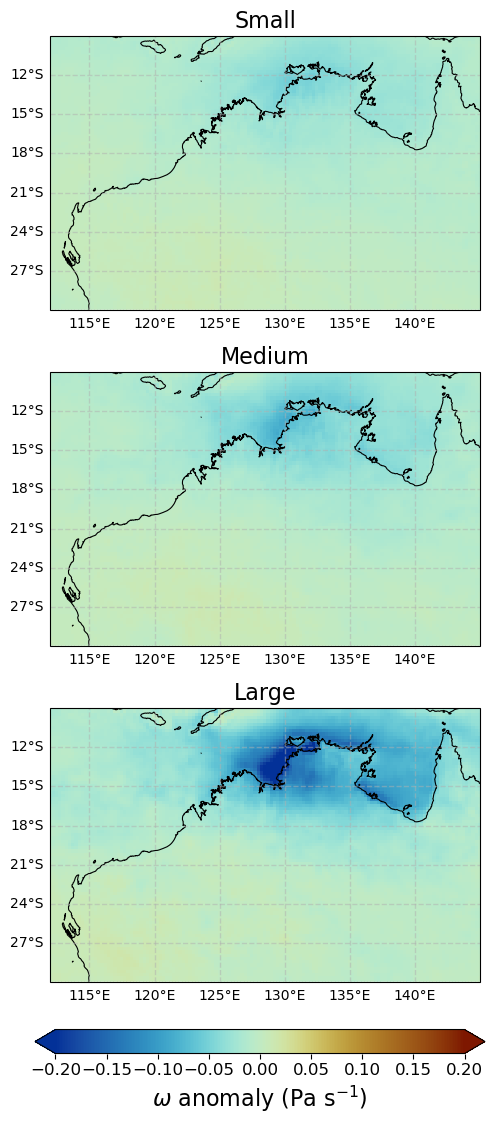

In [37]:
fig = plt.figure(figsize=(5, 12))

# First subplot
ax1 = fig.add_subplot(311, projection=ccrs.PlateCarree())
img1 = ax1.pcolor(small_w500_all.longitude, small_w500_all.latitude, 
                 small_w500_all.mean(dim="time"),
                 transform=ccrs.PlateCarree(), cmap="cmc.roma_r", 
                 vmin=-0.2, vmax=0.2)
ax1.coastlines('10m', color="black", linewidth=0.8)
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, alpha=0.5, linestyle='--')
gl1.top_labels=False   # suppress top labels
gl1.right_labels=False # suppress right labels
ax1.set_ylim(y_extent)
ax1.set_xlim(x_extent)
ax1.set_title("Small")
plt.tight_layout()
# First colorbar
# cbar1 = plt.colorbar(img1, ax=ax1, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  # pad controls the space between the colorbar and the plot
# cbar1.set_label("$\omega$ anomaly (Pa s$^{-1}$)")   # Change to desired colorbar title

# Second subplot
ax2 = fig.add_subplot(312, projection=ccrs.PlateCarree())
img2 = ax2.pcolor(mid_w500_all.longitude, mid_w500_all.latitude, 
                 mid_w500_all.mean(dim="time"),
                 transform=ccrs.PlateCarree(), cmap="cmc.roma_r", 
                 vmin=-0.2, vmax=0.2)
ax2.coastlines('10m', color="black", linewidth=0.8)
gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, alpha=0.5, linestyle='--')
gl2.top_labels=False   # suppress top labels
gl2.right_labels=False # suppress right labels
ax2.set_ylim(y_extent)
ax2.set_xlim(x_extent)
ax2.set_title("Medium")
plt.tight_layout()
# Second colorbar
# cbar2 = plt.colorbar(img2, ax=ax2, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  
# cbar2.set_label("$\omega$ anomaly (Pa s$^{-1}$)")   # Change to desired colorbar title


# Third subplot
ax3 = fig.add_subplot(313, projection=ccrs.PlateCarree())
img3 = ax3.pcolor(large_w500_all.longitude, large_w500_all.latitude, 
                 large_w500_all.mean(dim="time"),
                 transform=ccrs.PlateCarree(), cmap="cmc.roma_r", 
                 vmin=-0.2, vmax=0.2)
ax3.coastlines('10m', color="black", linewidth=0.8)
gl3 = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, alpha=0.5, linestyle='--')
gl3.top_labels=False   # suppress top labels
gl3.right_labels=False # suppress right labels
ax3.set_ylim(y_extent)
ax3.set_xlim(x_extent)
ax3.set_title("Large")

# third colorbar
# cbar3 = plt.colorbar(img3, ax=ax3, orientation='horizontal', pad=0.1, shrink=0.7,extend="both")  
# cbar3.set_label("$\omega$ anomaly (Pa s$^{-1}$)")  # Change to desired colorbar title

plt.tight_layout()
fig.subplots_adjust(bottom = 0.1)


cbar_ax = fig.add_axes([0.08, 0.09, 0.9, 0.02]) #[left, bottom, width, height]
cbar = fig.colorbar(img3,  cax = cbar_ax, orientation = "horizontal",extend="both")
cbar.ax.set_xlabel("$\omega$ anomaly (Pa s$^{-1}$)")
plt.savefig("/g/data/k10/dl6968/Rain_gauge_scale/figures/Darwin_composites_omega.png",dpi=200)

# Seasonality old clusters

In [6]:
extreme_dates = np.load("/g/data/k10/dl6968/Rain_gauge_scale/data/Darwin_extreme_dates.npy",allow_pickle=True)
clusters = np.load("/g/data/k10/dl6968/Rain_gauge_scale/data/Darwin_clusters_notau_median_mean_BL.npy",allow_pickle=True)

In [7]:
months = np.arange(0,12)+1
c1_case = np.zeros_like(months)
c2_case = np.zeros_like(months)
c3_case = np.zeros_like(months)

for i in range(0,len(extreme_dates[clusters==0])):
    mon_id = int(extreme_dates[clusters==0][i][5:7])-1
    c1_case[mon_id] += 1
for i in range(0,len(extreme_dates[clusters==1])):
    mon_id = int(extreme_dates[clusters==1][i][5:7])-1
    c2_case[mon_id] += 1
for i in range(0,len(extreme_dates[clusters==2])):
    mon_id = int(extreme_dates[clusters==2][i][5:7])-1
    c3_case[mon_id] += 1

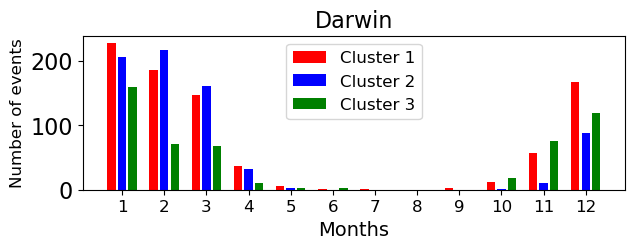

In [8]:
plt.figure(figsize=(7,2))
plt.bar(months-0.25, c1_case, color="r", label = "Small", width=0.2) # "salmon"
plt.bar(months, c2_case, color="b", label = "Medium", width=0.2) # "moccasin"

plt.bar(months+0.25, c3_case, color="g",label = "Large", width=0.2) # "skyblue"
plt.legend(loc="upper center")
plt.xlabel("Months",fontsize=14)
plt.ylabel("Number of events",fontsize=12)
plt.title("Darwin")
_ = plt.xticks(months)